# Notebook to Fit Synthetic Spitzer Light Curves of Transiting Planets using Gaussian Processes
## Coded by: Joel C. Schwartz – Postdoc, McGill University
## Gaussian Process Module Coded by: Jackson Hoffart & Max Lamberti — Undergrads, McGill University
## Last Updated: 02/27/17

In [1]:
import numpy as np
from scipy import optimize
from scipy.linalg import cho_factor, cho_solve
from scipy.interpolate import RectBivariateSpline
from scipy.integrate import quad
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as pat
%matplotlib inline

import emcee
import corner

import main_definitions as MD  # File where I'm keeping all the functions needed from now on

pi = np.pi

# Setup the Planetary System & Light Curve

In [2]:
Generate_key = False  # True to generate from scratch; False to load a data set that's already made
ExportLC_key = False  # True to save generated light (if generate key is also turned on)

folder_Name = '../data/main_LC_data/'
loadfile_Name = '170313_Scenario_001'

## Input Values — Edit these if generating
#### Some bogus combos won't work: for example, if the planet has a bigger radius than the star

In [3]:
if Generate_key == True:
    
    ## Planetary System
    Star_mass = 1.0  # Solar masses
    Star_radius = 1.0  # Solar radii
    Star_Teff = 5778  # Kelvin

    Planet_semimajor = 0.05  # AU
    Planet_radius = 1.0  # Jupiter radii: NEPTUNE would be about 0.3464, EARTH would be about 0.0892
    Planet_impact = 0.25  # Impact parameter: [0,1]

    Planet_Ag = 0.3  # Geometric albedo: [0,1.5]  — this is in whatever waveband is defined below
    Planet_AB = 0.2  # Bond albedo: [0,1]
    Planet_varepsilon = 0.35  # Heat recirculation efficiency: [0,1]


    ## Light Curve
    NperHr = 12  # Cadence of data, in points per hour
    Obs_orbits = 1.5  # How many orbits did you observe? Can be fractional and/or less than 1
    Frac_transinone = 0.75  # Time-fraction into 1ST OBSERVED ORBIT that transit happens (i.e. timing for everything)

    wavelength_Obs = 4.5  # 'Bolo' for bolometric, OR center of waveband in microns
    bandwidth_Obs = 1.0  # Anything for bolometric, OR full-width of wavelength channel in microns

    significance_decl = 10.0*np.ones(1)  # Significance of the eclipse (i.e. how many sigma is it detected at?)
    ratio_DelD_decl = 10.0*np.ones(1)  # Ratio of Detector Amplitude (in a given part of light curve) to Eclipse Depth


    ## Repoints, Centroids, Noise
    Frac_repoints = np.array([0,1.0]) # Time-fraction into WHOLE OBSERVATION repoints happen: MUST HAVE 0 and 1.0

    Noisy_cents_key = False  # Add some noise to centroids
    Frac_sigcent,Rhomax_cent = 0.01,0.5  # Fraction of centroid cluster for uncertainty; maximum covariance

    level_Vnoise = 0.1  # Uncertainty for noise in pixel sensitivity, relative to standard model being from 0 to 1
    Nzy_per_pix = 10  # Number of 'noisy points' to interpolate from, per pixel AND per axis

    Brown_key = False  # Extra Brownian noise signal
    ratio_Brown_DelD = 1.0*np.ones(1)
    
else:
    
    (Star_mass,Star_radius,Star_Teff,
     Planet_semimajor,Planet_radius,Planet_impact,Planet_Ag,Planet_AB,Planet_varepsilon,
     NperHr,Obs_orbits,Frac_transinone,wavelength_Obs,bandwidth_Obs,significance_decl,ratio_DelD_decl,
     Frac_repoints,Noisy_cents_key,Frac_sigcent,Rhomax_cent,level_Vnoise,Nzy_per_pix,
     Brown_key,ratio_Brown_DelD) = MD.LCloadGiv(folder_Name,loadfile_Name)

## Orbital Period
pln_Porb_days = MD.planet_P(Planet_semimajor,Star_mass)
pln_Porb_sec = pln_Porb_days*(24*3600)  # Number of days * 24 hr/day * 3600 sec/hr

## Planet Temperatures
pln_Tnought = MD.planet_Tirrad(Star_Teff,Star_radius,Planet_semimajor)
pln_Tday,pln_Tnight = MD.planet_Tdaynight(Planet_varepsilon,Planet_AB,pln_Tnought)

## Offset of light curve (1st order)
litecrv_Offdeg = MD.LC_offdeg(Planet_varepsilon)

## Properties of transit, eclipse, and phase variations
(delta_transit,power_transit,dur_transit_sec,
 delta_eclipse,dur_ineclipse_sec,dur_inegress_sec,
 delta_variations,
 delta_systemflux) = MD.LC_depths_durations(wavelength_Obs,bandwidth_Obs,
                                             Star_radius,Star_Teff,Planet_semimajor,pln_Porb_days,Planet_impact,
                                             Planet_radius,pln_Tday,pln_Tnight,Planet_Ag,litecrv_Offdeg)

## Time of transit in 1st observed orbit
transit_inone = Frac_transinone*pln_Porb_sec

## Data points per orbit and in whole light curve
NperOrb,N_LC = MD.pregen_Nvals(NperHr,Obs_orbits,pln_Porb_sec)

## Setting detector amplitude and photon noise, from calculated eclipse depth and chosen properties
setting_Delta_D = ratio_DelD_decl*delta_eclipse
within_ecl_N = int(NperOrb*((dur_ineclipse_sec + 2.0*dur_inegress_sec)/pln_Porb_sec))
ratio_SigF_decl = (within_ecl_N**0.5)/significance_decl  # Photon noise / Eclipse depth == Sqrt[N_ecl] / Signif_ecl
setting_SigF = ratio_SigF_decl*delta_eclipse

## Diagram of the Planetary System

main_definitions.py:567: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor('k')


IOError: [Errno 2] No such file or directory: 'example/system_visual.png'

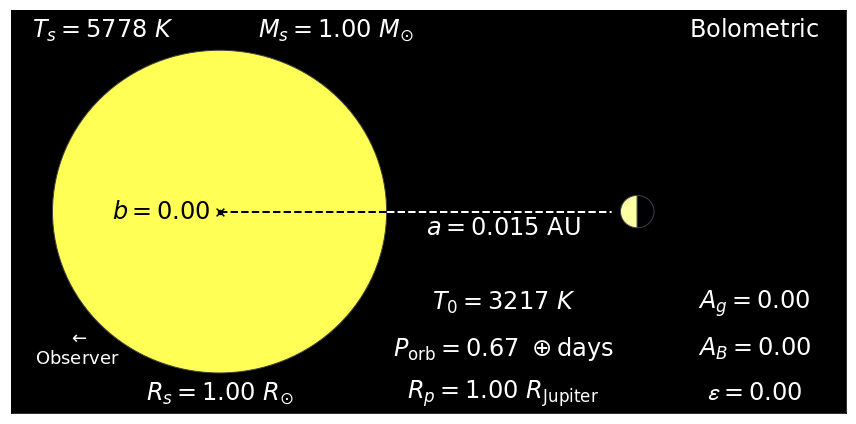

In [4]:
MD.system_visual(wavelength_Obs,Star_mass,Star_radius,Star_Teff,
                  Planet_semimajor,Planet_radius,Planet_impact,
                  Planet_Ag,Planet_AB,Planet_varepsilon,pln_Porb_days,pln_Tnought,pln_Tday,pln_Tnight)

## Centroids from Telescope Pointing Model
#### More sophisticated: can have multiple repoints now!

In [5]:
temp_time = np.linspace(0,Obs_orbits*pln_Porb_sec,N_LC)  # For 'telescope_pointing' function

if Generate_key == True:
    
    ## Perfect centroids
    (x0_perf,y0_perf,tm_inds,select_point,
     Jitter_vals,Wobble_vals,ShortDrift_vals,LongDrift_vals) = MD.centroiding(temp_time,Frac_repoints)

    ## Noisy centroids (if Noisy_cent_key == True, otherwise same as perfect centroids)
    x0_vals,y0_vals,Cov_true = MD.centroid_jiggle(Noisy_cents_key,x0_perf,y0_perf,N_LC,Frac_sigcent,Rhomax_cent)

    ## Creating the pixel noise grid to interpolate from
    xgrid_Fixed,ygrid_Fixed,Master_pixNoi = MD.preNoi_gridding(x0_perf,y0_perf,Nzy_per_pix)
    
else:
    
    (x0_perf,y0_perf,tm_inds,select_point,
     Jitter_vals,Wobble_vals,ShortDrift_vals,LongDrift_vals,
     x0_vals,y0_vals,Cov_true,xgrid_Fixed,ygrid_Fixed,Master_pixNoi) = MD.LCloadCen(folder_Name,loadfile_Name)

## Generate/Load the Light Curve

In [6]:
if Generate_key == True:
    
    ## [amplitude,Porb_planet in sec,phase offset,DC flux offset from 1.0,transit time in 1st observed orbit]
    Ast_true = np.array([0.5*delta_variations,
                         pln_Porb_sec,
                         litecrv_Offdeg*pi/180.0,
                         delta_systemflux,
                         transit_inone])
    ## [half transit duration,power of curve,depth]
    Trans_true = np.array([0.5*dur_transit_sec,
                         power_transit,
                         delta_transit])
    ## [half in-eclipse duration,ingress/egress duration,depth]
    Ecl_true = np.array([0.5*dur_ineclipse_sec,
                         dur_inegress_sec,
                         delta_eclipse])
    mu_true = np.array([0.0])  # Basically a legacy term (adds a systematic offset in the photon noise)
    SigF_true = setting_SigF  # Uncertainty of photon noise; already an array from earlier definition

    # GENERATE!!!
    (T,A_m,D_m,F_perf,F_dat,
     V_map,Vx_val,Vy_val) = MD.real_gen_model(xgrid_Fixed,ygrid_Fixed,Master_pixNoi,
                                               level_Vnoise,setting_Delta_D,tm_inds,select_point,True,
                                               NperOrb,N_LC,Obs_orbits,Ast_true,Trans_true,Ecl_true,
                                               x0_perf,y0_perf,mu_true,SigF_true)

    # Multiplying in Brownian noise, if wanted.
    F_perf,F_dat,Bro_noi = MD.brown_signal(Brown_key,ratio_Brown_DelD,F_perf,F_dat,A_m,D_m,mu_true,SigF_true,N_LC)
    
else:
    
    (Ast_true,Trans_true,Ecl_true,mu_true,SigF_true,
     T,A_m,D_m,F_perf,F_dat,V_map,Vx_val,Vy_val,Bro_noi) = MD.LCloadDat(folder_Name,loadfile_Name)

## Plot the light curve and pixel sensitivity maps!

IOError: [Errno 2] No such file or directory: 'example/stellar_flux.png'

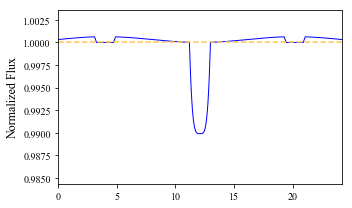

In [7]:
T_viz = T/3600
Blind_data = False  # Hide underlying models?
Highlight_astro = True  # If showing: focus on astro model?
Zoom_in = False  # Focus more on phase curve?

MD.LC_plotter(Blind_data,Highlight_astro,Zoom_in,T_viz,F_dat,A_m,D_m,F_perf,
               Brown_key,Bro_noi,delta_eclipse,significance_decl,ratio_DelD_decl)

MD.full_pixelsens(Vx_val,Vy_val,V_map,100,x0_perf,y0_perf)  # Number is contours to use

newmap_badmask,lx0,hx0,ly0,hy0 = MD.cent_mapplot(x0_perf,y0_perf,Vx_val[0,:],Vy_val[:,0])
Smap_bounds = [np.amin(Vx_val),np.amax(Vx_val),np.amin(Vy_val),np.amax(Vy_val)]
minviz,maxviz = np.amin(D_m),np.amax(D_m)

MD.cent_sensfigs(T_viz,x0_perf,y0_perf,lx0,hx0,ly0,hy0,V_map,newmap_badmask,Smap_bounds,minviz,maxviz)

In [8]:
MD.jackson_plot(Vx_val,Vy_val,100,T_viz,x0_perf,y0_perf,lx0,hx0,ly0,hy0,V_map,newmap_badmask,Smap_bounds,minviz,maxviz)

NameError: name 'lx0' is not defined

## Save the light curve data

In [ ]:
savefile_Name = 'Test_Scenario_001'

if (Generate_key == True) and (ExportLC_key == True):
    MD.LCdumpGiv(folder_Name,savefile_Name,Star_mass,Star_radius,Star_Teff,
                  Planet_semimajor,Planet_radius,Planet_impact,Planet_Ag,Planet_AB,Planet_varepsilon,
                  NperHr,Obs_orbits,Frac_transinone,wavelength_Obs,bandwidth_Obs,significance_decl,ratio_DelD_decl,
                  Frac_repoints,Noisy_cents_key,Frac_sigcent,Rhomax_cent,level_Vnoise,Nzy_per_pix,
                  Brown_key,ratio_Brown_DelD)
    MD.LCdumpCen(folder_Name,savefile_Name,x0_perf,y0_perf,tm_inds,select_point,
                  Jitter_vals,Wobble_vals,ShortDrift_vals,LongDrift_vals,
                  x0_vals,y0_vals,Cov_true,xgrid_Fixed,ygrid_Fixed,Master_pixNoi)
    MD.LCdumpDat(folder_Name,savefile_Name,Ast_true,Trans_true,Ecl_true,mu_true,SigF_true,
                  T,A_m,D_m,F_perf,F_dat,V_map,Vx_val,Vy_val,Bro_noi)
else:
    print('Exporting passed by')

# Setup the Models to Fit With

## Gaussian Process (G-type)

### Marginalising over the Model Posterior using MCMC

#### Hyperparameters

In [ ]:
'''
Define the features and true astro parameter variables (here we optimize the 
hyperparameters using the true parameters. In principle, the hyperparameter optimization should
also work moderately well using some initial guess.)
'''

features = np.array([T, x0_perf, y0_perf, F_dat])
true_params = np.array([Ast_true[0],Ast_true[1],Ast_true[2],Ast_true[3],Ast_true[4],Ecl_true[0],Ecl_true[1],Ecl_true[2],Trans_true[0],Trans_true[1],Trans_true[2],Obs_orbits])
n_cadence = NperHr

# initial hyperparameters guess, theta_hypers[i]: 0: Axy, 1: At, 2: Lx, 3: Ly, 4: Lt, 5: Noise
theta_hypers = np.array([1.0, 1.0, 0.5, 0.5, 5000,0.0005])

# define the size of the initial MCMC ball, ~3 orders of magnitude smaller than the expected values

mc_ball = np.array([0.002,0.002,0.001,0.001,10,0.000006])
ndim = len(theta_hypers) # dimension of parameter-space
nwalkers = 16 # arbitrarily used 2*ndim + 4, I'm using very conservative numbers for all MCMC parameters, since it's already running too slowly as is
p0 = [np.array(theta_hypers) + mc_ball * np.random.randn(ndim)
      for i in xrange(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, MD.log_prob_hypers, args=(features,true_params,n_cadence))

print("Running first burn-in...")
sampler.reset()

# Re-sample the walkers near the best walker from the previous burn-in.
p0 = [np.array(theta_hypers) + mc_ball * np.random.randn(ndim)
      for i in xrange(nwalkers)]
p0, _, _ = sampler.run_mcmc(p0, 10)

print("Running second burn-in...")
samples = sampler.flatchain
lnp = sampler.flatlnprobability
sampler.reset()

p0 = [samples[np.argmax(lnp)] + 1e-8 * np.random.randn(ndim) for i in xrange(nwalkers)]
p0, _, _ = sampler.run_mcmc(p0, 100)


print("Running production...")
samples = sampler.flatchain
lnp = sampler.flatlnprobability
sampler.run_mcmc(p0, 20)

p0 = [samples[np.argmax(lnp)] + 1e-8 * np.random.randn(ndim) for i in xrange(nwalkers)]
sampler.run_mcmc(p0, 400)

samples = sampler.flatchain
lnp = sampler.flatlnprobability

#### Corner plots

In [ ]:
burnin = 200
samples = sampler.chain[:, burnin, :].reshape((-1,ndim))
fig = corner.corner(samples, labels=["$Axy$","At","Lx","Ly","Lt","Noise"])


#### Parameters

In [ ]:
optimized_hypers = samples[np.argmax(lnp)]

# pre-computing all covariance matrices etc.
K = MD.compute_Cov_Matrix(features,optimized_hypers)
KSig = K + optimized_hypers[-1] * np.identity(len(K))
factor, flag = cho_factor(KSig)

# initial parameter guesses
theta_params = np.array([5.0e-03, 9.0e+04, 3.14, 5.0e-02, 2.65e+05,5.0e+03,5.5e+03,0.5,1.5e+03,4.0,0.5])

ndim = len(theta_params)
nwalkers = 30
mc_ball = np.array([1e-06,1.0,1e-03,1.0e-05,1.0e+02,1.0,1.0,0.0001,1.0,1.0e-03,1.0e-03])

p0 = [np.array(theta_params) + mc_ball * np.random.randn(ndim)
      for i in xrange(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, MD.log_prob_params, args=(features,factor,flag,n_cadence))

print("Running first burn-in...")
samples = sampler.flatchain
lnp = sampler.flatlnprobability
sampler.reset()

# Re-sample the walkers near the best walker from the previous burn-in.
p0 = [samples[np.argmax(lnp)] + 1e-8 * np.random.randn(ndim) for i in xrange(nwalkers)]
p0, _, _ = sampler.run_mcmc(p0, 100) #250

print("Running second burn-in...")
samples = sampler.flatchain
lnp = sampler.flatlnprobability
sampler.reset()

p0 = [samples[np.argmax(lnp)] + 1e-8 * np.random.randn(ndim) for i in xrange(nwalkers)]

p0, _, _ = sampler.run_mcmc(p0, 100) #250
sampler.reset()

print("Running production...")
samples = sampler.flatchain
lnp = sampler.flatlnprobability
sampler.reset()

p0 = [samples[np.argmax(lnp)] + 1e-8 * np.random.randn(ndim) for i in xrange(nwalkers)]

sampler.run_mcmc(p0, 400) #1000

#### Corner plots

In [ ]:
burnin = 200
samples = sampler.chain[:, burnin, :].reshape((-1,ndim))
fig = corner.corner(samples, labels=["$Amp$","$Period$","$Phase$","$Dlt_flux$","$TCent$","$EHwid$","$Ingress$","$EDepth$","$THwid$","$Pow$","$TDepth$"], truths=true_params)

## Optimize Parameters Using Nelder Mead

In [ ]:
# optimized_hypers = optimize.minimize(MD.log_likelihood_hypers,theta0_hyp,args=(features,true_params,n_cadence),method='Nelder-Mead')
# #optimized_hypers = np.array([9.30393548e-1,-6.63078966e-9,1.45246665e-2,5.28909727e-2,9.39520039e+2,1.15646459e-14])

In [ ]:
# theta0_par = np.array([9.0e-3,4e+5,5e-1,1e-2,2.64618521e+05,3e+3,5e+3,2e-2,7e+3,4e+0,3e-1,1.5])

In [ ]:
# K = MD.compute_Cov_Matrix(features,optimized_hypers)
# KSig = K + optimized_hypers[-1] * np.identity(len(K))
# # inv_KSig = MD.linalg.cholesky(KSig)
# # logdet_KSig = MD.linalg.slogdet(KSig)[1]
# factor, flag = cho_factor(KSig)

In [ ]:
# # print MD.log_likelihood_params(astro_guess,features,inv_KSig,logdet_KSig,NperHr)

# optimized_astros = optimize.minimize(MD.log_likelihood_params,theta0_par,args=(features,inv_KSig,logdet_KSig,NperHr),method='Nelder-Mead')
# print optimized_astros

In [ ]:
# print optimized_astros.x

In [ ]:
# theta_par = optimized_astros.x
# astro, ecl, trans = theta_par[0:5], theta_par[5:8], theta_par[8:11]
# n_per_orb = int(np.around((theta_par[1]/3600.0)*NperHr))  # period in hrs * data per hr
# t_dummy = np.linspace(-0.25*theta_par[1],0.75*theta_par[1],n_per_orb)
# t_full = T
# astro_mdl = MD.perf_astro_model(t_full,t_dummy,astro,trans,ecl)
# plt.plot(T,astro_mdl,'b-')
# plt.plot(T,F_dat,'kx')
# plt.show()


In [ ]:
# astro, ecl, trans = theta0_par[0:5], theta0_par[5:8], theta0_par[8:11]
# n_per_orb = int(np.around((theta0_par[1]/3600.0)*NperHr))  # period in hrs * data per hr
# t_dummy = np.linspace(-0.25*theta0_par[1],0.75*theta0_par[1],n_per_orb)
# t_full = T
# astro_mdl = MD.perf_astro_model(t_full,t_dummy,astro,trans,ecl)
# plt.plot(T,astro_mdl,'b-')
# plt.plot(T,F_dat,'kx')
# plt.show()